In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image17933.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image13595.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image06359.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image01767.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image01837.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image12441.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image01925.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image11305.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image11327.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image01865.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image01328.jpg
/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Erythema/image15415.jpg
/kaggle/input/kv

In [2]:
import os
dataset_path = "/kaggle/input/kvasir-comp-dt"

def get_class_distribution(root_path):
    class_counts = {}
    total_images = 0

    for root, dirs, files in os.walk(root_path):
        image_files = [f for f in files if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        if image_files:  # Only process folders containing images
            class_name = os.path.basename(root).strip().replace(" ", "-")  # Clean class names
            num_images = len(image_files)

            if num_images:
                class_counts[class_name] = num_images
                total_images += num_images

    return class_counts, total_images

# Run the function
class_counts, total_images = get_class_distribution(dataset_path)

# Print output
print(f"Total classes: {len(class_counts)}")
print(f"Total images: {total_images}")
print("Images per class:")
for class_name, count in sorted(class_counts.items()):
    print(f"{class_name}: {count}")

Total classes: 10
Total images: 53738
Images per class:
Angioectasia: 1154
Bleeding: 834
Erosion: 2694
Erythema: 691
Foreign-Body: 792
Lymphangiectasia: 796
Normal: 28662
Polyp: 1162
Ulcer: 663
Worms: 158


In [3]:
from tensorflow import keras
import os

data_dir = "/kaggle/input/kvasir-comp-dt"
train_dir = os.path.join(data_dir, 'training')
val_dir = os.path.join(data_dir, 'validation')
img_size = (224, 224)
batch_size = 32
num_classes = 10  

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen = datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/kvasir-comp-dt/training'

In [4]:
from tensorflow import keras
import os

data_dir = "/kaggle/input/kvasir-comp-dt/Data_Restructured"
train_dir = os.path.join(data_dir, 'training')
val_dir = os.path.join(data_dir, 'validation')
img_size = (224, 224)
batch_size = 32
num_classes = 10  

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen = datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

Found 37606 images belonging to 10 classes.
Found 16132 images belonging to 10 classes.


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,
                                     BatchNormalization, Input, Conv2D, Concatenate,
                                     Reshape, Multiply, Add, Activation, Lambda)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetB7

def cbam_block(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]
    
    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)
    
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    max_pool = Reshape((1, 1, channel))(max_pool)
    
    shared_mlp = Sequential([
        Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True),
        Dense(channel, kernel_initializer='he_normal', use_bias=True)
    ])
    
    mlp_avg = shared_mlp(avg_pool)
    mlp_max = shared_mlp(max_pool)
    
    channel_attention = Add()([mlp_avg, mlp_max])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_refined = Multiply()([input_feature, channel_attention])
    
    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    
    spatial_attention = Conv2D(filters=1, kernel_size=7, strides=1, padding='same',
                               activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    refined_feature = Multiply()([channel_refined, spatial_attention])
    
    return refined_feature

In [6]:
input_img = Input(shape=(224,224,3))
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_tensor=input_img)
base_model.trainable = True

x = base_model.output
x = cbam_block(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_img, outputs=output)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 64)   │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 66,398,275 (253.29 MB)

 Trainable params: 66,087,036 (252.10 MB)

 Non-trainable params: 311,239 (1.19 MB)

In [7]:
model.fit(train_gen, validation_data=val_gen, epochs=20)

model.save("transfer_learning_cbn.keras")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [8]:
model.fit(train_gen, validation_data=val_gen, epochs=20)

model.save("transfer_learning_cbn.keras")

Epoch 1/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1539s 1s/step - accuracy: 0.7528 - loss: 1.0734 - val_accuracy: 0.9111 - val_loss: 0.3351
Epoch 2/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1377s 1s/step - accuracy: 0.9193 - loss: 0.2811 - val_accuracy: 0.9248 - val_loss: 0.2524
Epoch 3/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1376s 1s/step - accuracy: 0.9470 - loss: 0.1711 - val_accuracy: 0.9257 - val_loss: 0.2611
Epoch 4/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1380s 1s/step - accuracy: 0.9641 - loss: 0.1189 - val_accuracy: 0.9298 - val_loss: 0.2738
Epoch 5/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1375s 1s/step - accuracy: 0.9731 - loss: 0.0898 - val_accuracy: 0.9321 - val_loss: 0.2746
Epoch 6/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1377s 1s/step - accuracy: 0.9822 - loss: 0.0569 - val_accuracy: 0.8957 - val_loss: 0.4230
Epoch 7/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1385s 1s/step - accuracy: 0.9715 - loss: 0.0923 - val_accuracy: 0.9355 - val_loss: 0.2679
Epoch 8/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1388s 1s/step - accuracy: 0.9875 -

In [9]:
class_labels = val_gen.class_indices
class_labels

{'Angioectasia': 0,
 'Bleeding': 1,
 'Erosion': 2,
 'Erythema': 3,
 'Foreign Body': 4,
 'Lymphangiectasia': 5,
 'Normal': 6,
 'Polyp': 7,
 'Ulcer': 8,
 'Worms': 9}

In [16]:
import numpy as np
import tensorflow as tf
from PIL import Image

mapping = {
    0: 'Angioectasia',
    1: 'Bleeding',
    2: 'Erosion',
    3: 'Erythema',
    4: 'Foreign Body',
    5: 'Lymphangiectasia',
    6: 'Normal',
    7: 'Polyp',
    8: 'Ulcer',
    9: 'Worms'
}

#Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/input/classification_model/keras/default/1/transfer_learning_cbn.keras")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare a single image (load and preprocess)
def preprocess_image(image_path, input_shape=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(input_shape)
    img_array = np.array(img, dtype=np.float32)
    # Normalize the image (same preprocessing as during training)
    img_array = img_array / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load and preprocess a test image
test_image = preprocess_image("/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Foreign Body/3ada4222967f421d_10589.jpg")

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], test_image)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Process the prediction
predicted_class = np.argmax(output_data[0])
confidence = output_data[0][predicted_class]

print(f"Predicted class: {mapping[predicted_class]}")
print(f"Confidence: {confidence:.4f}")


ValueError: Model provided has model identifier '

In [13]:
import numpy as np
import tensorflow as tf
from PIL import Image

mapping = {
    0: 'Angioectasia',
    1: 'Bleeding',
    2: 'Erosion',
    3: 'Erythema',
    4: 'Foreign Body',
    5: 'Lymphangiectasia',
    6: 'Normal',
    7: 'Polyp',
    8: 'Ulcer',
    9: 'Worms'
}

# Load the TFLite model
#interpreter = tf.lite.Interpreter(model_path="/kaggle/input/mymodel/model.tflite")
#interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare a single image (load and preprocess)
def preprocess_image(image_path, input_shape=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(input_shape)
    img_array = np.array(img, dtype=np.float32)
    # Normalize the image (same preprocessing as during training)
    img_array = img_array / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load and preprocess a test image
test_image = preprocess_image("/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Foreign Body/3ada4222967f421d_10589.jpg")

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], test_image)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Process the prediction
predicted_class = np.argmax(output_data[0])
confidence = output_data[0][predicted_class]

print(f"Predicted class: {mapping[predicted_class]}")
print(f"Confidence: {confidence:.4f}")


NameError: name 'interpreter' is not defined

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def evaluate_with_metrics_limited(interpreter, val_gen, class_labels, max_images=200):
    all_images = []
    all_labels = []
    val_gen.reset()
    for i in range(len(val_gen)):
        x_batch, y_batch = val_gen[i]
        for j in range(x_batch.shape[0]):
            all_images.append(x_batch[j])
            all_labels.append(y_batch[j])
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    total_images = len(all_images)
    print(f"Total images in val_gen: {total_images}")
    indices = np.arange(total_images)
    np.random.shuffle(indices)
    chosen_indices = indices[:max_images]
    X_sample = all_images[chosen_indices]
    Y_sample = all_labels[chosen_indices]
    print(f"Randomly selected {len(X_sample)} images for evaluation.")
    y_true = []
    y_pred = []
    y_pred_probs = []
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    for i in range(len(X_sample)):
        img = np.expand_dims(X_sample[i], axis=0)
        true_label_idx = np.argmax(Y_sample[i])
        y_true.append(true_label_idx)
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        pred_label_idx = np.argmax(output_data[0])
        y_pred.append(pred_label_idx)
        y_pred_probs.append(output_data[0])
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    accuracy = np.sum(y_true_np == y_pred_np) / len(y_true_np)
    print(f"\nValidation Accuracy on random subset: {accuracy:.4f}")
    report = classification_report(y_true_np, y_pred_np, target_names=class_labels, digits=4)
    print("\nClassification Report:")
    print(report)
    cm = confusion_matrix(y_true_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)
    classwise_acc = cm.diagonal() / cm.sum(axis=1)
    for idx, label in enumerate(class_labels):
        print(f"Accuracy for class '{label}': {classwise_acc[idx]:.4f}")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Random 200 Images)')
    plt.savefig('confusion_matrix_200.png')
    plt.show()
    num_classes = len(class_labels)
    if num_classes > 2:
        try:
            y_true_bin = label_binarize(y_true_np, classes=range(num_classes))
            y_pred_probs = np.array(y_pred_probs)
            plt.figure(figsize=(10, 8))
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                roc_auc_val = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_val:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            plt.savefig('roc_curves_200.png')
            plt.show()
            print("\nROC curves generated successfully!")
        except Exception as e:
            print(f"\nCould not generate ROC curves: {e}")
    return {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'classwise_accuracy': classwise_acc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }

interpreter = tf.lite.Interpreter(model_path="/kaggle/input/mymodel/model.tflite")
interpreter.allocate_tensors()
metrics = evaluate_with_metrics_limited(interpreter, val_gen, class_labels, max_images=200)
print(metrics['accuracy'])import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def evaluate_with_metrics_limited(interpreter, val_gen, class_labels, max_images=200):
    all_images = []
    all_labels = []
    val_gen.reset()
    for i in range(len(val_gen)):
        x_batch, y_batch = val_gen[i]
        for j in range(x_batch.shape[0]):
            all_images.append(x_batch[j])
            all_labels.append(y_batch[j])
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    total_images = len(all_images)
    print(f"Total images in val_gen: {total_images}")
    indices = np.arange(total_images)
    np.random.shuffle(indices)
    chosen_indices = indices[:max_images]
    X_sample = all_images[chosen_indices]
    Y_sample = all_labels[chosen_indices]
    print(f"Randomly selected {len(X_sample)} images for evaluation.")
    y_true = []
    y_pred = []
    y_pred_probs = []
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    for i in range(len(X_sample)):
        img = np.expand_dims(X_sample[i], axis=0)
        true_label_idx = np.argmax(Y_sample[i])
        y_true.append(true_label_idx)
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        pred_label_idx = np.argmax(output_data[0])
        y_pred.append(pred_label_idx)
        y_pred_probs.append(output_data[0])
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    accuracy = np.sum(y_true_np == y_pred_np) / len(y_true_np)
    print(f"\nValidation Accuracy on random subset: {accuracy:.4f}")
    report = classification_report(y_true_np, y_pred_np, target_names=class_labels, digits=4)
    print("\nClassification Report:")
    print(report)
    cm = confusion_matrix(y_true_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)
    classwise_acc = cm.diagonal() / cm.sum(axis=1)
    for idx, label in enumerate(class_labels):
        print(f"Accuracy for class '{label}': {classwise_acc[idx]:.4f}")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Random 200 Images)')
    plt.savefig('confusion_matrix_200.png')
    plt.show()
    num_classes = len(class_labels)
    if num_classes > 2:
        try:
            y_true_bin = label_binarize(y_true_np, classes=range(num_classes))
            y_pred_probs = np.array(y_pred_probs)
            plt.figure(figsize=(10, 8))
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                roc_auc_val = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_val:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            plt.savefig('roc_curves_200.png')
            plt.show()
            print("\nROC curves generated successfully!")
        except Exception as e:
            print(f"\nCould not generate ROC curves: {e}")
    return {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'classwise_accuracy': classwise_acc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }

interpreter = tf.lite.Interpreter(model_path="/kaggle/input/mymodel/model.tflite")
interpreter.allocate_tensors()
metrics = evaluate_with_metrics_limited(interpreter, val_gen, class_labels, max_images=200)
print(metrics['accuracy'])

SyntaxError: invalid syntax (<ipython-input-11-8f39dd48193b>, line 99)

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def evaluate_with_metrics_limited(interpreter, val_gen, class_labels, max_images=200):
    all_images = []
    all_labels = []
    val_gen.reset()
    for i in range(len(val_gen)):
        x_batch, y_batch = val_gen[i]
        for j in range(x_batch.shape[0]):
            all_images.append(x_batch[j])
            all_labels.append(y_batch[j])
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    total_images = len(all_images)
    print(f"Total images in val_gen: {total_images}")
    indices = np.arange(total_images)
    np.random.shuffle(indices)
    chosen_indices = indices[:max_images]
    X_sample = all_images[chosen_indices]
    Y_sample = all_labels[chosen_indices]
    print(f"Randomly selected {len(X_sample)} images for evaluation.")
    y_true = []
    y_pred = []
    y_pred_probs = []
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    for i in range(len(X_sample)):
        img = np.expand_dims(X_sample[i], axis=0)
        true_label_idx = np.argmax(Y_sample[i])
        y_true.append(true_label_idx)
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        pred_label_idx = np.argmax(output_data[0])
        y_pred.append(pred_label_idx)
        y_pred_probs.append(output_data[0])
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    accuracy = np.sum(y_true_np == y_pred_np) / len(y_true_np)
    print(f"\nValidation Accuracy on random subset: {accuracy:.4f}")
    report = classification_report(y_true_np, y_pred_np, target_names=class_labels, digits=4)
    print("\nClassification Report:")
    print(report)
    cm = confusion_matrix(y_true_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)
    classwise_acc = cm.diagonal() / cm.sum(axis=1)
    for idx, label in enumerate(class_labels):
        print(f"Accuracy for class '{label}': {classwise_acc[idx]:.4f}")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Random 200 Images)')
    plt.savefig('confusion_matrix_200.png')
    plt.show()
    num_classes = len(class_labels)
    if num_classes > 2:
        try:
            y_true_bin = label_binarize(y_true_np, classes=range(num_classes))
            y_pred_probs = np.array(y_pred_probs)
            plt.figure(figsize=(10, 8))
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                roc_auc_val = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_val:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            plt.savefig('roc_curves_200.png')
            plt.show()
            print("\nROC curves generated successfully!")
        except Exception as e:
            print(f"\nCould not generate ROC curves: {e}")
    return {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'classwise_accuracy': classwise_acc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }

interpreter = tf.lite.Interpreter(model_path="/kaggle/input/classification_model/keras/default/1/transfer_learning_cbn.keras")
interpreter.allocate_tensors()
metrics = evaluate_with_metrics_limited(interpreter, val_gen, class_labels, max_images=200)
print(metrics['accuracy'])

ValueError: Model provided has model identifier '

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_stored_predictions(class_labels):
    # Load stored true labels and predictions
    y_true_np = np.load("y_true.npy")  # True labels
    y_pred_np = np.load("y_pred.npy")  # Predicted labels
    y_pred_probs = np.load("y_pred_probs.npy")  # Predicted probabilities

    # Compute accuracy
    accuracy = np.sum(y_true_np == y_pred_np) / len(y_true_np)
    print(f"\nValidation Accuracy: {accuracy:.4f}")

    # Generate classification report
    report = classification_report(y_true_np, y_pred_np, target_names=class_labels, digits=4)
    print("\nClassification Report:")
    print(report)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)

    # Class-wise accuracy
    classwise_acc = cm.diagonal() / cm.sum(axis=1)
    for idx, label in enumerate(class_labels):
        print(f"Accuracy for class '{label}': {classwise_acc[idx]:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Plot ROC Curves (if multi-class)
    num_classes = len(class_labels)
    if num_classes > 2:
        try:
            y_true_bin = label_binarize(y_true_np, classes=range(num_classes))
            y_pred_probs = np.array(y_pred_probs)

            plt.figure(figsize=(10, 8))
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                roc_auc_val = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_val:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            plt.savefig('roc_curves.png')
            plt.show()
            print("\nROC curves generated successfully!")

        except Exception as e:
            print(f"\nCould not generate ROC curves: {e}")

    return {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'classwise_accuracy': classwise_acc
    }

# Example usage
class_labels = [ 'Angioectasia',
'Bleeding',
'Erosion',
    'Erythema',
    'Foreign Body',
     'Lymphangiectasia',
     'Normal',
    'Polyp',
    'Ulcer',
     'Worms']  # Modify based on your dataset
metrics = evaluate_stored_predictions(class_labels)
print(metrics['accuracy'])


FileNotFoundError: [Errno 2] No such file or directory: 'y_true.npy'

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model("/kaggle/working/")
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


OSError: SavedModel file does not exist at: /kaggle/working//{saved_model.pbtxt|saved_model.pb}

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp7pngacqy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135416932183104: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135416919194288: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135417179897024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416829128272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416829130032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416829126512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416829127040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416829129856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416789468784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416789469488: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [24]:
import tensorflow as tf

model = tf.keras.models.load_model("/kaggle/working/transfer_learning_cbn.keras")
model.summary()  # To check the model architecture


ValueError: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda

# Define the missing function
def custom_lambda_function(x):
    return tf.reduce_mean(x, axis=[1, 2])  # Example function, modify based on your model

# Register the function
custom_objects = {"custom_lambda_function": Lambda(custom_lambda_function)}

# Load the model with custom objects
model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# Print model summary to verify
model.summary()


NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 7, 7, 2560), dtype=float32, sparse=False, name=keras_tensor_7862>',)
  • kwargs={'mask': 'None'}

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def evaluate_with_metrics_limited(interpreter, val_gen, class_labels, max_images=200):
    all_images = []
    all_labels = []
    val_gen.reset()
    for i in range(len(val_gen)):
        x_batch, y_batch = val_gen[i]
        for j in range(x_batch.shape[0]):
            all_images.append(x_batch[j])
            all_labels.append(y_batch[j])
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    total_images = len(all_images)
    print(f"Total images in val_gen: {total_images}")
    indices = np.arange(total_images)
    np.random.shuffle(indices)
    chosen_indices = indices[:max_images]
    X_sample = all_images[chosen_indices]
    Y_sample = all_labels[chosen_indices]
    print(f"Randomly selected {len(X_sample)} images for evaluation.")
    y_true = []
    y_pred = []
    y_pred_probs = []
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    for i in range(len(X_sample)):
        img = np.expand_dims(X_sample[i], axis=0)
        true_label_idx = np.argmax(Y_sample[i])
        y_true.append(true_label_idx)
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        pred_label_idx = np.argmax(output_data[0])
        y_pred.append(pred_label_idx)
        y_pred_probs.append(output_data[0])
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    accuracy = np.sum(y_true_np == y_pred_np) / len(y_true_np)
    print(f"\nValidation Accuracy on random subset: {accuracy:.4f}")
    report = classification_report(y_true_np, y_pred_np, target_names=class_labels, digits=4)
    print("\nClassification Report:")
    print(report)
    cm = confusion_matrix(y_true_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)
    classwise_acc = cm.diagonal() / cm.sum(axis=1)
    for idx, label in enumerate(class_labels):
        print(f"Accuracy for class '{label}': {classwise_acc[idx]:.4f}")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Random 200 Images)')
    plt.savefig('confusion_matrix_200.png')
    plt.show()
    num_classes = len(class_labels)
    if num_classes > 2:
        try:
            y_true_bin = label_binarize(y_true_np, classes=range(num_classes))
            y_pred_probs = np.array(y_pred_probs)
            plt.figure(figsize=(10, 8))
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                roc_auc_val = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_val:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            plt.savefig('roc_curves_200.png')
            plt.show()
            print("\nROC curves generated successfully!")
        except Exception as e:
            print(f"\nCould not generate ROC curves: {e}")
    return {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'classwise_accuracy': classwise_acc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }

interpreter = tf.lite.Interpreter(model_path="/kaggle/input/mymodel/model.tflite")
interpreter.allocate_tensors()
metrics = evaluate_with_metrics_limited(interpreter, val_gen, class_labels, max_images=200)
print(metrics['accuracy'])

In [32]:
import os

model_path = "/kaggle/working/transfer_learning_cbn.keras"

if os.path.exists(model_path):
    print("✅ Model file exists!")
else:
    print("❌ Model file not found. Check the path.")


✅ Model file exists!


In [34]:
# Remove Lambda layers (if possible)
for i, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.Lambda):
        print(f"Removing Lambda layer at index {i}")
        model.layers.pop(i)

# Save model without Lambda layer
model.save("/kaggle/working/new_model.keras")


Removing Lambda layer at index 822
Removing Lambda layer at index 823


In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.allow_custom_ops = True  # Allow Lambda layers
tflite_model = converter.convert()

# Save as .tflite
with open("/kaggle/working/model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model converted to TFLite with custom ops allowed!")


Saved artifact at '/tmp/tmppk5m3jnb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135416932183104: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135416919194288: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135417179897024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416829128272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416829130032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416829126512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416829127040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416829129856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416789468784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416789469488: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [36]:
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/model.tflite")
interpreter.allocate_tensors()
print("✅ TFLite model loaded successfully!")


✅ TFLite model loaded successfully!


In [2]:
from tensorflow import keras
import os

data_dir = "/kaggle/input/kvasir-comp-dt/Data_Restructured/"
train_dir = os.path.join(data_dir, 'training')
val_dir = os.path.join(data_dir, 'validation')
img_size = (224, 224)
batch_size = 32
num_classes = 10  

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen = datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

Found 37606 images belonging to 10 classes.
Found 16132 images belonging to 10 classes.


In [5]:
class_labels = val_gen.class_indices
class_labels

{'Angioectasia': 0,
 'Bleeding': 1,
 'Erosion': 2,
 'Erythema': 3,
 'Foreign Body': 4,
 'Lymphangiectasia': 5,
 'Normal': 6,
 'Polyp': 7,
 'Ulcer': 8,
 'Worms': 9}

Total images in val_gen: 16132
Classification images for evaluation.

Validation Accuracy : 0.9700

Classification Report:
                  precision    recall  f1-score   support

    Angioectasia     1.0000    0.8750    0.9333         8
        Bleeding     1.0000    0.8333    0.9091         6
         Erosion     0.7143    0.6250    0.6667         8
        Erythema     0.6667    1.0000    0.8000         4
    Foreign Body     1.0000    1.0000    1.0000         4
Lymphangiectasia     1.0000    1.0000    1.0000         8
          Normal     0.9870    0.9935    0.9902       153
           Polyp     1.0000    1.0000    1.0000         4
           Ulcer     1.0000    1.0000    1.0000         4
           Worms     1.0000    1.0000    1.0000         1

        accuracy                         0.9700       200
       macro avg     0.9368    0.9327    0.9299       200
    weighted avg     0.9720    0.9700    0.9698       200


Confusion Matrix:
[[  7   0   0   1   0   0   0   0   0   0]


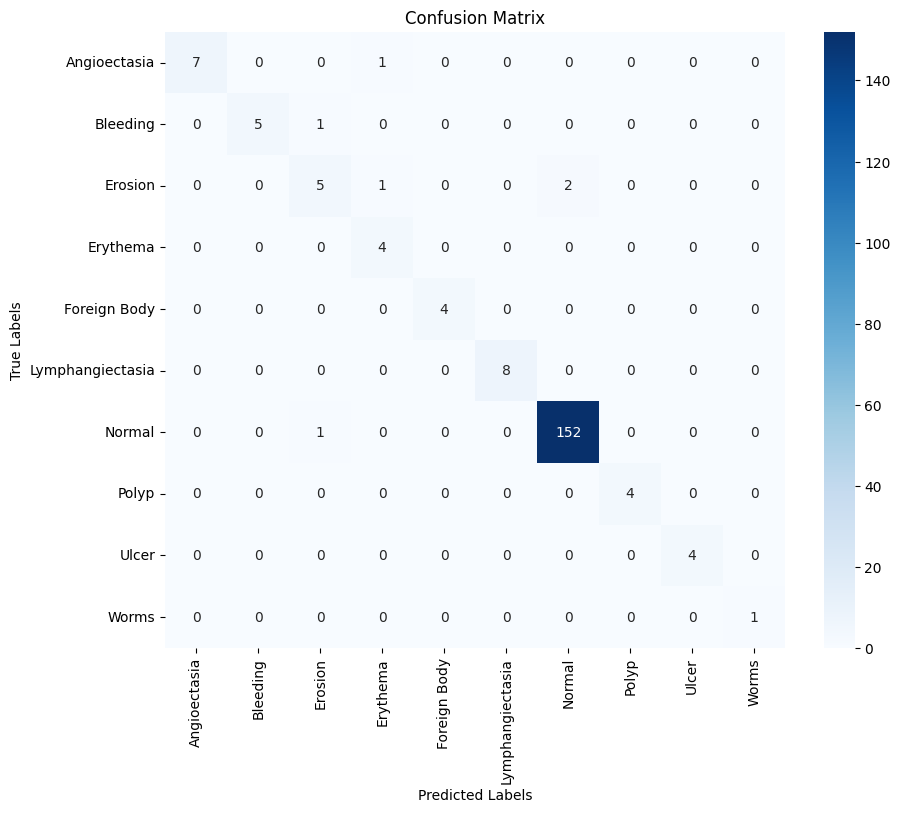


Could not generate ROC curves: 0
0.97


<Figure size 1000x800 with 0 Axes>

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def evaluate_with_metrics_limited(interpreter, val_gen, class_labels, max_images=200):
    all_images = []
    all_labels = []
    val_gen.reset()
    for i in range(len(val_gen)):
        x_batch, y_batch = val_gen[i]
        for j in range(x_batch.shape[0]):
            all_images.append(x_batch[j])
            all_labels.append(y_batch[j])
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    total_images = len(all_images)
    print(f"Total images in val_gen: {total_images}")
    indices = np.arange(total_images)
    np.random.shuffle(indices)
    chosen_indices = indices[:max_images]
    X_sample = all_images[chosen_indices]
    Y_sample = all_labels[chosen_indices]
    print(f"Classification images for evaluation.")
    y_true = []
    y_pred = []
    y_pred_probs = []
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    for i in range(len(X_sample)):
        img = np.expand_dims(X_sample[i], axis=0)
        true_label_idx = np.argmax(Y_sample[i])
        y_true.append(true_label_idx)
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        pred_label_idx = np.argmax(output_data[0])
        y_pred.append(pred_label_idx)
        y_pred_probs.append(output_data[0])
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    accuracy = np.sum(y_true_np == y_pred_np) / len(y_true_np)
    print(f"\nValidation Accuracy : {accuracy:.4f}")
    report = classification_report(y_true_np, y_pred_np, target_names=class_labels, digits=4)
    print("\nClassification Report:")
    print(report)
    cm = confusion_matrix(y_true_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)
    classwise_acc = cm.diagonal() / cm.sum(axis=1)
    for idx, label in enumerate(class_labels):
        print(f"Accuracy for class '{label}': {classwise_acc[idx]:.4f}")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_200.png')
    plt.show()
    num_classes = len(class_labels)
    if num_classes > 2:
        try:
            y_true_bin = label_binarize(y_true_np, classes=range(num_classes))
            y_pred_probs = np.array(y_pred_probs)
            plt.figure(figsize=(10, 8))
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                roc_auc_val = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_val:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            plt.savefig('roc_curves_200.png')
            plt.show()
            print("\nROC curves generated successfully!")
        except Exception as e:
            print(f"\nCould not generate ROC curves: {e}")
    return {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'classwise_accuracy': classwise_acc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }

interpreter = tf.lite.Interpreter(model_path="/kaggle/input/classy_model/tensorflow2/default/1/model.tflite")
interpreter.allocate_tensors()
metrics = evaluate_with_metrics_limited(interpreter, val_gen, class_labels, max_images=200)
print(metrics['accuracy'])

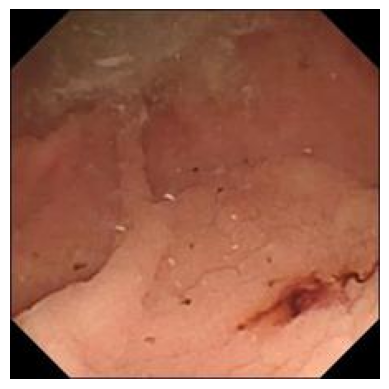

Predicted class: Bleeding


In [16]:
import numpy as np
import tensorflow as tf
from PIL import Image

mapping = {
    0: 'Angioectasia',
    1: 'Bleeding',
    2: 'Erosion',
    3: 'Erythema',
    4: 'Foreign Body',
    5: 'Lymphangiectasia',
    6: 'Normal',
    7: 'Polyp',
    8: 'Ulcer',
    9: 'Worms'
}

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/input/classy_model/tensorflow2/default/1/model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare a single image (load and preprocess)
def preprocess_image(image_path, input_shape=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(input_shape)
    img_array = np.array(img, dtype=np.float32)
    # Normalize the image (same preprocessing as during training)
    img_array = img_array / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load and preprocess a test image
test_image = preprocess_image("/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Bleeding/04a78ef00c5245e0_11216.jpg")

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], test_image)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Process the prediction
predicted_class = np.argmax(output_data[0])

import cv2
import matplotlib.pyplot as plt

image_path = "/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Bleeding/04a78ef00c5245e0_11216.jpg"

# Load image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (Matplotlib expects RGB)

# Display image
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.show()


print(f"Predicted class: {mapping[predicted_class]}")


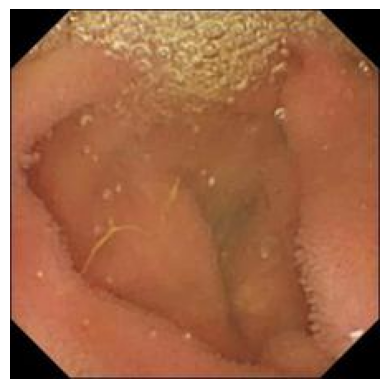

Predicted class: Lymphangiectasia


In [17]:
test_image = preprocess_image("/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Lymphangiectasia/04a78ef00c5245e0_12351.jpg")

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], test_image)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Process the prediction
predicted_class = np.argmax(output_data[0])

import cv2
import matplotlib.pyplot as plt

image_path = "/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Lymphangiectasia/04a78ef00c5245e0_12351.jpg"

# Load image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (Matplotlib expects RGB)

# Display image
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.show()


print(f"Predicted class: {mapping[predicted_class]}")



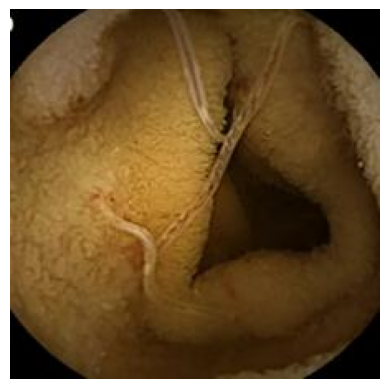

Predicted class: Worms


In [18]:
test_image = preprocess_image("/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Worms/worm1_1416.jpg")

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], test_image)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Process the prediction
predicted_class = np.argmax(output_data[0])

import cv2
import matplotlib.pyplot as plt

image_path = "/kaggle/input/kvasir-comp-dt/Data_Restructured/validation/Worms/worm1_1416.jpg"

# Load image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (Matplotlib expects RGB)

# Display image
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.show()


print(f"Predicted class: {mapping[predicted_class]}")



In [36]:
# Print input shape
print("Model expects input shape:", input_details[0]['shape'])

Model expects input shape: [  1 224 224   3]


In [35]:
def preprocess_image(image_path="/kaggle/input/vce-testing/Test set with seperated folders of each class label", target_size=(224, 224)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to model's input size
    image = image.astype(np.float32) / 255.0  # Normalize pixel values (0-1)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image




In [38]:
# Define a dictionary to map class indices to class names
class_labels = {
    0: "Angioectasia",
    1: "Bleeding",
    2: "Erosion",
    3: "Erythema",
    4: "Foreign Body",
    5: "Lymphangiectasia",
    6: "Normal",
    7: "Polyp",
    8: "Ulcer",
    9: "Worms"
}


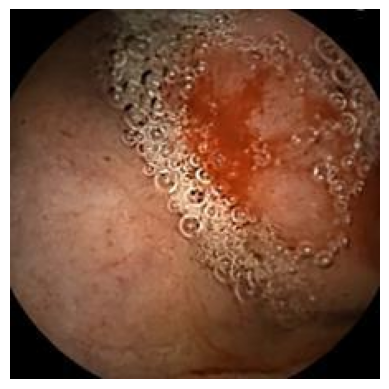

Image: /kaggle/input/vce-testing/Test set with seperated folders of each class label/Bleeding/1hLJMKHRjG.jpg | Predicted Class: Bleeding


In [46]:
# Run inference on a single test image
test_image_path = "/kaggle/input/vce-testing/Test set with seperated folders of each class label/Bleeding/1hLJMKHRjG.jpg"
input_data = preprocess_image(test_image_path)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get the predicted class index
predicted_class_index = np.argmax(output_data)

# Map index to class name
predicted_class_name = class_labels[predicted_class_index]
import cv2
import matplotlib.pyplot as plt

image_path = test_image_path

# Load image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (Matplotlib expects RGB)

# Display image
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.show()

print(f"Image: {test_image_path} | Predicted Class: {predicted_class_name}")


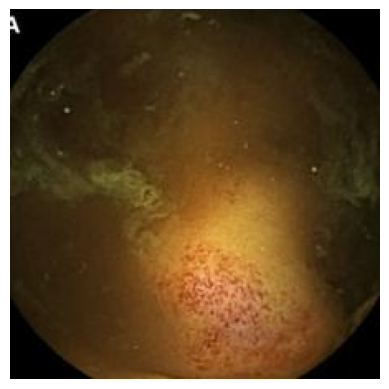

Image: /kaggle/input/vce-testing/Test set with seperated folders of each class label/Angioectasia/gczTME1gBT.jpg | Predicted Class: Ulcer


In [60]:
# Run inference on a single test image
test_image_path = "/kaggle/input/vce-testing/Test set with seperated folders of each class label/Angioectasia/q0GC7RDoCi.jpg"
input_data = preprocess_image(test_image_path)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get the predicted class index
predicted_class_index = np.argmax(output_data)

# Map index to class name
predicted_class_name = class_labels[predicted_class_index]
import cv2
import matplotlib.pyplot as plt

image_path = test_image_path

# Load image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (Matplotlib expects RGB)

# Display image
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.show()

print(f"Image: {test_image_path} | Predicted Class: {predicted_class_name}")


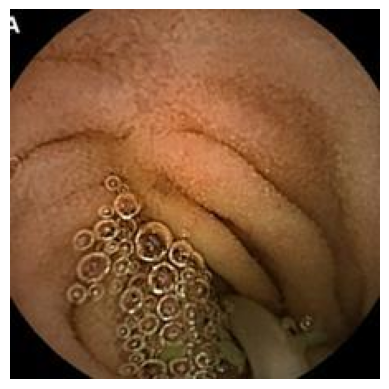

Image: /kaggle/input/vce-testing/Test set with seperated folders of each class label/Worms/AVrpob5cx3.jpg | Predicted Class: Worms


In [67]:
# Run inference on a single test image
test_image_path = "/kaggle/input/vce-testing/Test set with seperated folders of each class label/Worms/AVrpob5cx3.jpg"
input_data = preprocess_image(test_image_path)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get the predicted class index
predicted_class_index = np.argmax(output_data)

# Map index to class name
predicted_class_name = class_labels[predicted_class_index]
import cv2
import matplotlib.pyplot as plt

image_path = test_image_path

# Load image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (Matplotlib expects RGB)

# Display image
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.show()

print(f"Image: {test_image_path} | Predicted Class: {predicted_class_name}")


In [70]:
import tensorflow as tf
import numpy as np
import os
import cv2
from sklearn.metrics import classification_report, accuracy_score

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/input/classy_model/tensorflow2/default/1/model.tflite")
interpreter.allocate_tensors()

# Get input & output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input shape (e.g., (1, 224, 224, 3))
input_shape = input_details[0]['shape']
print(input_shape)


[  1 224 224   3]


In [71]:
def preprocess_image(image_path="/kaggle/input/vce-testing/Test set with seperated folders of each class label"):
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (if needed)
    img = cv2.resize(img, (input_shape[1], input_shape[2]))  # Resize to model input size
    img = img / 255.0  # Normalize (only if done during training)
    img = np.expand_dims(img, axis=0).astype(np.float32)  # Add batch dimension
    return img


In [72]:
# Define class labels (should match training labels)
class_labels = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 
                'Foreign Body', 'Lymphangiectasia', 'Normal', 
                'Polyp', 'Ulcer', 'Worms']

# Load test images & labels
test_dir = "/kaggle/input/vce-testing/Test set with seperated folders of each class label"  # Change to your test dataset path

test_images = []
test_labels = []

for class_name in class_labels:
    class_dir = os.path.join(test_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        test_images.append(img_path)
        test_labels.append(class_labels.index(class_name))  # Store class index


In [77]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files  # Use this for uploading an image in Colab

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/input/classy_model/tensorflow2/default/1/model.tflite")
interpreter.allocate_tensors()

# Get input & output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Model input shape
input_shape = input_details[0]['shape']

# Define test dataset path
test_dir = "/kaggle/input/vce-testing/Test set with seperated folders of each class label"

# Get class labels (folder names)
class_labels = sorted(os.listdir(test_dir))  # Sorting ensures index matches model training

# Initialize counters
correct_predictions = 0
total_images = 0
class_correct = {cls: 0 for cls in class_labels}
class_total = {cls: 0 for cls in class_labels}
'''
def preprocess_image(image_path):
    """ Preprocess image to match model input """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (input_shape[1], input_shape[2]))  # Resize
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0).astype(np.float32)  # Add batch dimension
    return img
    '''

def predict_image(image_path="/kaggle/input/vce-testing/Test set with seperated folders of each class label/Angioectasia/283qQRGfoB.jpg"):
    """ Predict class of a single image """
    img = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output)
    return class_labels[predicted_class]

# **STEP 1: Evaluate Model on Full Test Dataset**
print("\nEvaluating on Test Dataset...\n")
for class_name in tqdm(class_labels):
    class_folder = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_folder):
        continue
    
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        if not os.path.isfile(image_path):
            continue
        
        # Get prediction
        predicted_class = predict_image(image_path)
        
        # Update counters
        class_total[class_name] += 1
        total_images += 1
        if predicted_class == class_name:
            class_correct[class_name] += 1
            correct_predictions += 1

# **STEP 2: Compute & Display Test Accuracy**
overall_accuracy = correct_predictions / total_images * 100
print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%\n")

# **STEP 3: Compute & Display Class-wise Accuracy**
print("Class-wise Accuracy:\n")
for class_name in class_labels:
    if class_total[class_name] > 0:
        acc = class_correct[class_name] / class_total[class_name] * 100
        print(f"  {class_name}: {acc:.2f}% ({class_correct[class_name]}/{class_total[class_name]})")
'''
# **STEP 4: Upload Image & Predict**
uploaded = files.upload()
for filename in uploaded.keys():
    image_path = filename  # Get the uploaded image path
    predicted_class = predict_image(image_path)

    # Display the uploaded image with predicted class
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()
'''


Evaluating on Test Dataset...



100%|██████████| 10/10 [17:23<00:00, 104.31s/it]


Overall Test Accuracy: 9.21%

Class-wise Accuracy:

  Angioectasia: 8.11% (3/37)
  Bleeding: 65.57% (219/334)
  Erosion: 2.04% (1/49)
  Erythema: 0.00% (0/17)
  Foreign Body: 10.42% (5/48)
  Lymphangiectasia: 0.00% (0/155)
  Normal: 2.75% (97/3526)
  Polyp: 0.00% (0/11)
  Ulcer: 28.73% (52/181)
  Worms: 100.00% (27/27)


'\n# **STEP 4: Upload Image & Predict**\nuploaded = files.upload()\nfor filename in uploaded.keys():\n    image_path = filename  # Get the uploaded image path\n    predicted_class = predict_image(image_path)\n\n    # Display the uploaded image with predicted class\n    img = cv2.imread(image_path)\n    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n    plt.imshow(img)\n    plt.axis(\'off\')\n    plt.title(f"Predicted: {predicted_class}")\n    plt.show()\n'